In [1]:
import pandas as pd
import cv2
import json
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np

In [3]:
data_dir = '/data/AlgProj/niezl/TCT/1_DataBase/20190702/'
csv_path = '/data/AlgProj/niezl/TCT/TCT_Data/Misc/TCT标注_0702/影像标注结果.csv'
save_dir = '/data/AlgProj/tct_yaoms/data/tct_0702_doctor_labels_comparasion/'

In [37]:
class doctor_labels_comparasion():
    def __init__(self, data_dir, csv_path, save_dir):
        self.data_dir = data_dir
        self.labels = pd.read_csv(csv_path)
        self.save_dir = save_dir
        self.float2int()
        
    def float2int(self):
        self.labels['x_min'] = 0
        self.labels['y_min'] = 0
        self.labels['x_max'] = 0
        self.labels['y_max'] = 0
        for idx in range(len(self.labels)):
            cur_dict = json.loads(self.labels.iloc[idx,:]['影像结果'])
            self.labels.loc[idx,'x_min'] = int(cur_dict['point1']['x'])
            self.labels.loc[idx,'y_min'] = int(cur_dict['point1']['y'])
            self.labels.loc[idx,'x_max'] = int(cur_dict['point2']['x'])
            self.labels.loc[idx,'y_max'] = int(cur_dict['point2']['y'])
    
    def comparasion(self):
        series = self.labels['序列编号'].unique()
        for s in series:
            dataframe = self.labels.loc[self.labels['序列编号']==s]
            doctors = dataframe['用户姓名'].unique()
            if len(doctors) == 2:
                df_doc1 = dataframe.loc[dataframe['用户姓名']==doctors[0]]
                df_doc2 = dataframe.loc[dataframe['用户姓名']==doctors[1]]
                
                #read img
                series = df_doc1['序列编号'].unique()
                img_dir = self.data_dir + series[0] + '/'
                img_name = os.listdir(img_dir)[0]
                img_path = img_dir + img_name
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                color = ((255, 0, 0),(0, 0, 255))
                location = ((50, 50), (50, 100))
                img = self.draw_box(img, df_doc1, color[0], location[0])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = self.draw_box(img, df_doc2, color[1], location[1])
            elif len(doctors) < 2:
                df_doc1 = dataframe.loc[dataframe['用户姓名']==doctors[0]]
                series = df_doc1['序列编号'].unique()
                img_dir = self.data_dir + series[0] + '/'
                img_name = os.listdir(img_dir)[0]
                img_path = img_dir + img_name
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                color = (255, 0, 0)
                location = (50, 50)
                img = self.draw_box(img, df_doc1, color, location)
            
            #save img
            self.save_img(img, s, doctors)
            
    def draw_box(self, img, df, color, location):
        d_cate = {'1':'ASC-US', '2':'ASC-H', '3':'L-SIL', '4':'H-SIL', '5':'SCC', '6':'AGC-NOS', '7':'AGC-neoplastic', '8':'AIS', '9':'AC'}
        height, width = img.shape[:2]
        font_path = '/usr/share/fonts/truetype/simsun.ttf'
        
        for idx in df.index:
            x_min = max(0, df.loc[idx, 'x_min'])
            y_min = max(0, df.loc[idx, 'y_min'])
            x_max = min(width, df.loc[idx, 'x_max'])
            y_max = min(height, df.loc[idx, 'y_max'])
            img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 5)
            label_num = df.loc[idx, '恶性细胞分类']
            label = d_cate[str(label_num)]
            locate_x = x_min
            if (y_min - 50 < 0):
                locate_y = y_max - 5
            else:
                locate_y = y_min - 5
            cv2.putText(img, label, (locate_x, locate_y), cv2.FONT_HERSHEY_SIMPLEX, 1.0, color, 3)
            
        doctor = df['用户姓名'].unique()

        img = Image.fromarray(img)
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype(font_path, 45, encoding='utf-8')
        draw.text(location, doctor[0], color, font)
        
        img = cv2.cvtColor(np.array(img),cv2.COLOR_RGB2BGR) 
        return img
    
            
    def save_img(self,img, series,doctors):
        img_save_dir = self.save_dir + series + '/'
        if not os.path.exists(img_save_dir):
            os.mkdir(img_save_dir)
        
        img_name_pre = ''
        if len(doctors) == 1:
            img_name_pre = doctors[0] + '-标注'
        else:
            doctors =list(doctors)
            img_name_pre = '-'.join(doctors) + '-共同标注'
        
        img_name = img_name_pre + '.jpg'
        img_save_path = img_save_dir + img_name
        if not os.path.exists(img_save_path):
            cv2.imwrite(img_save_path, img)
                

In [36]:
tct_0702 = doctor_labels_comparasion(data_dir, csv_path, save_dir)
tct_0702.labels['用户姓名'].unique()

array(['陈燕华', '杜有凤', '张晶晶', '汪利萍'], dtype=object)

In [38]:
tct_0702.comparasion()

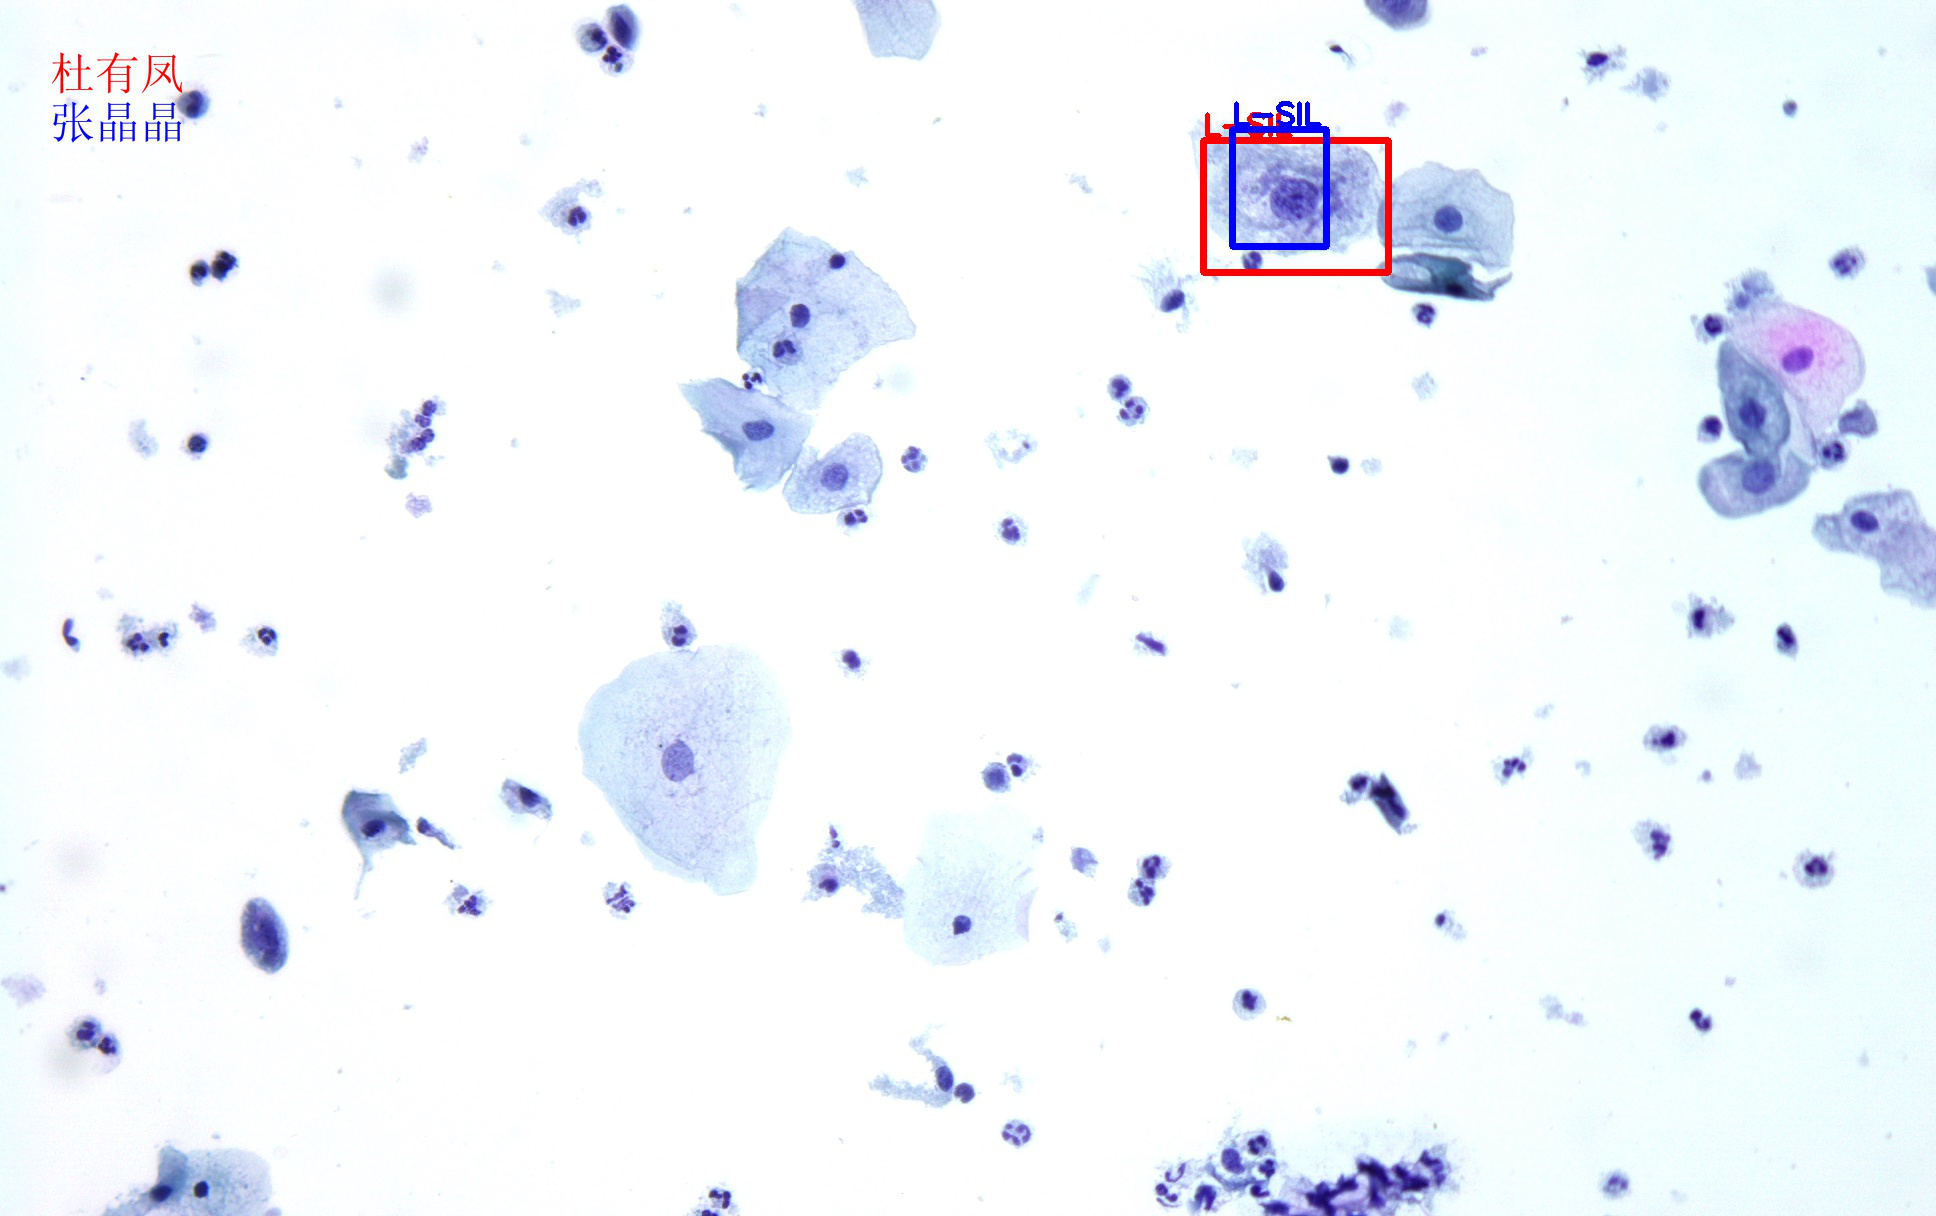

In [12]:
files = os.listdir(save_dir)
dirs = save_dir+files[103]
img_name = os.listdir(dirs)[0]
img_path = dirs+'/'+img_name

Image.open(img_path)

In [68]:
type(files[0])

str

In [5]:
df = pd.read_csv(csv_path)
df.head()

,用户手机号,用户姓名,影像结果编号,检查编号,序列编号,开始时间,提交时间,自定义内容,阴阳性,病灶,影像工具,影像结果类型,影像结果,恶性细胞分类,TCT病灶类型,核膜形状,核仁,染色质,细胞核大小,细胞形态
0,13482871504,陈燕华,304180,5b1bdfa1835e4dffa4f1c4f50c521283,52c07daaf2c504ecc8e4178c9660f4430956ca59,2019-06-28 19:26:11,2019-06-28 19:26:27,NaN,NaN,ANNO9,RECTANGLE,2,"{""point1"":{""x"":762.8940568475452,""y"":1063.2351...",1,1,2,3,1,2,1
1,13482871504,陈燕华,304179,8939c52600254fecb27ed6671c0e3e46,df3f2828bf8682ebd2fee6be1ea90b973d8b66cb,2019-06-28 19:25:55,2019-06-28 19:26:12,NaN,NaN,ANNO9,RECTANGLE,2,"{""point1"":{""x"":650.3359173126615,""y"":37.705426...",1,1,2,3,1,2,1
2,13482871504,陈燕华,304178,2392fe046fd14a538e5e560b1e6aac7e,5127380792dab348ac11de8b1bd4d9a81cd28e5b,2019-06-28 19:25:40,2019-06-28 19:25:55,NaN,NaN,ANNO9,RECTANGLE,2,"{""point1"":{""x"":587.8036175710595,""y"":102.73901...",1,1,2,3,1,2,1
3,13482871504,陈燕华,304177,8fd32e3a983e411ca5c5347bff707fa6,a264ed0b4a1b9bf83f470ce2b9fb6c8d772c172e,2019-06-28 19:25:26,2019-06-28 19:25:40,NaN,NaN,ANNO9,RECTANGLE,2,"{""point1"":{""x"":1020.5271317829458,""y"":290.3359...",1,1,2,3,1,2,1
4,13482871504,陈燕华,304184,092f777d7d754b44aeb0f741c3434b90,52ca420052072ca219b66572abc414fc932128d5,2019-06-28 19:29:15,2019-06-28 19:29:29,NaN,NaN,ANNO9,RECTANGLE,2,"{""point1"":{""x"":443.45098039215696,""y"":919.2854...",1,1,2,3,1,2,1


In [6]:
df['恶性细胞分类'].value_counts()

1    1748
2    1487
4    1173
3     346
6      44
5       9
7       8
Name: 恶性细胞分类, dtype: int64

In [7]:
d_cate = {'1':'ASC-US', '2':'ASC-H', '3':'L-SIL', '4':'H-SIL', '5':'SCC', '6':'AGC-NOS', '7':'AGC-neoplastic', '8':'AIS', '9':'AC'}